In [1]:
%matplotlib inline
import altair as alt
import pandas as pd
%load_ext watermark
%watermark -iv -v -d

altair 2.4.1
pandas 0.24.2
2019-04-22 

CPython 3.7.3
IPython 7.4.0


## Aims
The aim of this notebook is to analyze our RSVP data and see which schools I have to encourage to send more e-mails to their listservs. This RSVP data was collected until the night before the conference which is on the 23rd of April, 2019.
We are using pandas for data wrangling and altair for plotting.

In [2]:
df = pd.read_csv('rsvp_data.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

rsvp_no                time               institution
0        1 2019-03-07 16:58:00  Non-academic Institution
1        2 2019-03-14 19:11:00                     Other
2        3 2019-03-18 14:28:00  Non-academic Institution
3        4 2019-03-19 16:33:00                      CUNY
4        5 2019-03-19 16:45:00                      CUNY

In [3]:
df['counts'] = df.groupby('institution').cumcount()+1

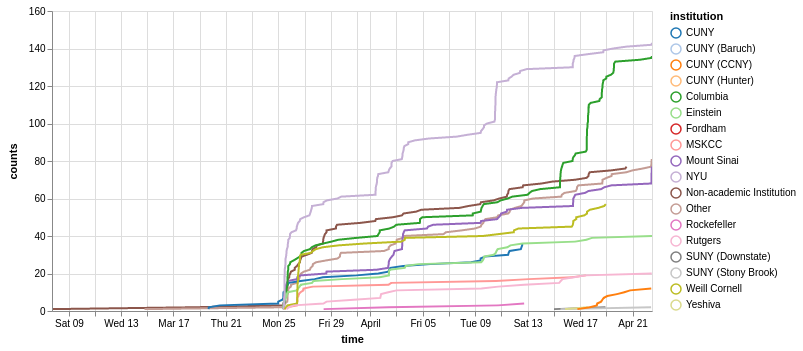

In [4]:
alt.Chart(df).properties(width=600).mark_line().encode(
    alt.Color('institution',
        scale=alt.Scale(scheme='category20')),
    x='time',
    y='counts',
    tooltip='institution'
).interactive()

We used this information around April 11th to motivate additional advertising efforts by Columbia and other schools. 
What we had noticed was that after weeks of advertising, one clickbaity e-mail at NYU still brought in a huge upwards spike in RSVPs (around 10th of April), meaning that the common fear of over-exposing a target audience to ads would diminish their willingness to RSVP for the conference. 

We can tell that `NYU` was bringing the most RSVPs on April 11th, but we the colleagues at `Columbia` were able to close the gap. One also has to consider that `CUNY` was split up into different labels late in the process. If one were to add the CUNY RSVPs up towards the end, they would fall between Weill Cornell and Einstein. Additionally we see quite a few RSVPs for `Non-academic Institution`, emphasizing that at our conference you don't just have the panelists and speakers to network with, but also your fellow attendees from industry.

### When were the biggest spikes in signups/ e-mail blasts

The aim here is to have some fun with the numbers to estimate when each university received e-mail blasts, by looking at the differential in signups over time. 

We will make use of the following solution, which attempts to compute the local gradient from incoherently sampled data:

https://stackoverflow.com/questions/41780489/python-pandas-how-to-calculate-derivative-gradient

In [5]:
dummy = pd.concat((df['rsvp_no'].diff()/ df['time'].diff().dt.total_seconds(), df['time']), axis=1).rename(columns={0:'differential'})
dummy.head()

differential                time
0           NaN 2019-03-07 16:58:00
1      0.000002 2019-03-14 19:11:00
2      0.000003 2019-03-18 14:28:00
3      0.000011 2019-03-19 16:33:00
4      0.001389 2019-03-19 16:45:00

Let's look at all RSVPs together:

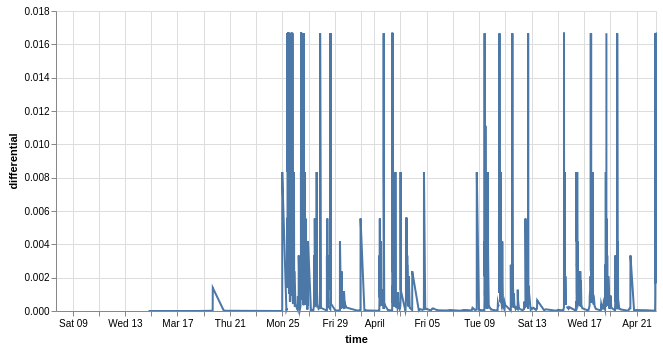

In [6]:
alt.Chart(dummy).properties(width=600).mark_line().encode(
    x='time',
    y='differential'
)

Now let's look at how this same pictures looks when we calculate these data by institution:

In [7]:
differentials =  df.groupby('institution').apply(
    lambda group: pd.concat([group['time'], group['counts'].diff()/ df['time'].diff().dt.total_seconds()], axis=1)
).reset_index().dropna().rename(columns={0:'differential'})\
.loc[:,['institution', 'time', 'differential']]
differentials.head()

institution                time  differential
4        CUNY 2019-03-19 16:45:00      0.001389
5        CUNY 2019-03-20 12:58:00      0.000014
6        CUNY 2019-03-24 23:46:00      0.000003
7        CUNY 2019-03-24 23:48:00      0.008333
8        CUNY 2019-03-25 07:25:00      0.000036

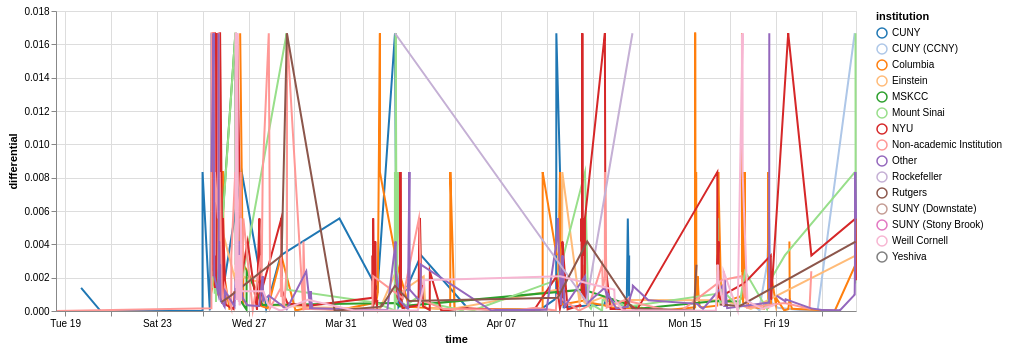

In [8]:
alt.Chart(differentials).properties(width=800).mark_line().encode(
    alt.Color('institution',
        scale=alt.Scale(scheme='category20')),
    x='time',
    y='differential',
    tooltip='institution'

)

This is not terribly helpful looking, the only thing we can tell from this is that there are not necessarily many more bursts of NYU signups. 

It would probably be a lot easier to read if we used a windowed count of RSVPs. So let's try counting the number of RSVPs in a 2h window: 

In [9]:
rsvp_2h_avg_institution = df.groupby('institution').apply(             # we group by institution
    lambda frame: frame.set_index('time').counts.rolling('2H').count() # for every institution, we want to do a rolling average of unique RSVPs with a 2h time window
).reset_index(                                                         # resetting the index, so it's easier to consume for altair
)
rsvp_2h_avg_institution.groupby('institution').head().head(10)         # showing that the counts make sense - if time points are 2h apart, then they are counted together

institution                time  counts
0            CUNY 2019-03-19 16:33:00     1.0
1            CUNY 2019-03-19 16:45:00     2.0
2            CUNY 2019-03-20 12:58:00     1.0
3            CUNY 2019-03-24 23:46:00     1.0
4            CUNY 2019-03-24 23:48:00     2.0
36  CUNY (Baruch) 2019-04-22 10:59:00     1.0
37    CUNY (CCNY) 2019-04-16 19:02:00     1.0
38    CUNY (CCNY) 2019-04-17 18:19:00     1.0
39    CUNY (CCNY) 2019-04-18 06:35:00     1.0
40    CUNY (CCNY) 2019-04-18 07:14:00     2.0

So let's plot these windowed counts:

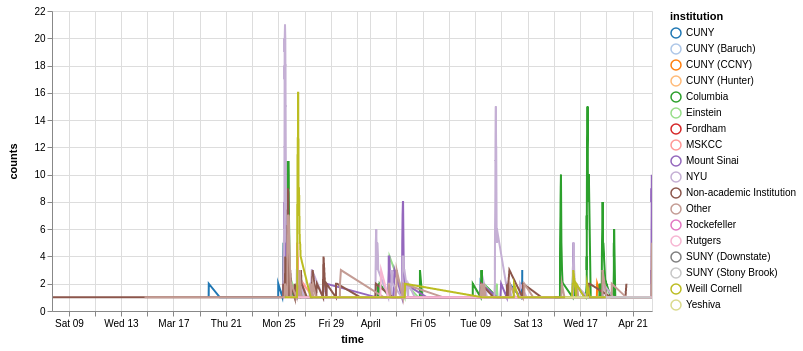

In [10]:
alt.Chart(rsvp_2h_avg_institution).properties(width=600).mark_line().encode(
    x='time',
    y='counts',
    color = alt.Color('institution',
        scale=alt.Scale(scheme='category20')), 
    tooltip='institution'

).interactive()

We can pretty clearly see that there is a burst of peaks from Columbia in the last two weeks and if you look clearly, there was another burst right around March 25th, which is when we all started advertising.
NYU, only has a couple of peaks but major activity at each of those peaks. This could be tied to a larger audience (the PhD program at NYU is one of the larger ones in the country), stronger receptiveness for career development opportunities, or more effective marketing.

You may also ask why we have RSVPs from before then and that's because some of our members already RSVPed for the conference when the website was not public yet.

Let's look at these counts institution by institution:

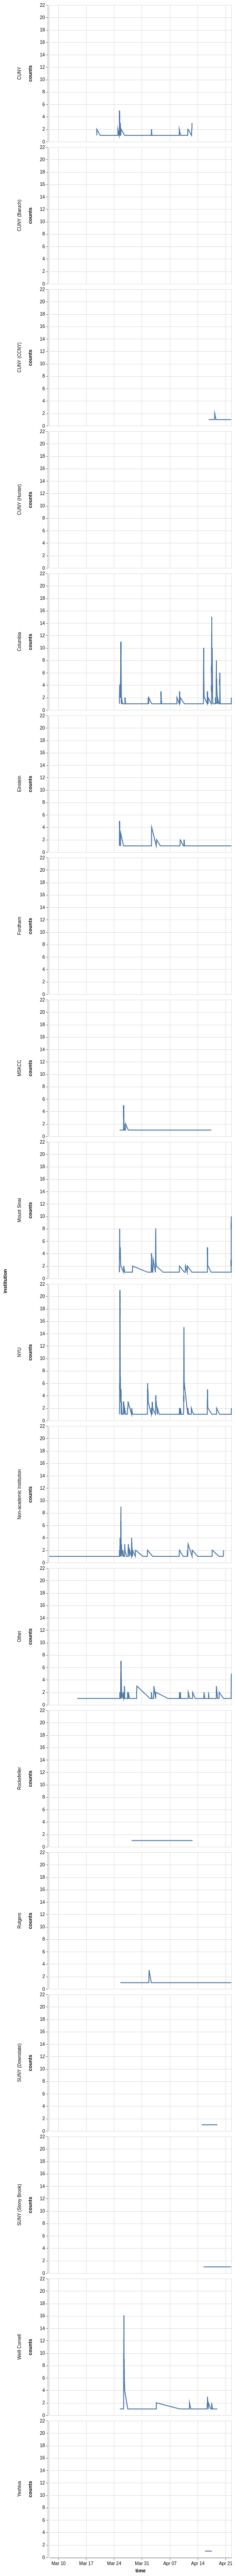

In [11]:
alt.Chart(rsvp_2h_avg_institution).mark_line().encode(
    x='time',
    y='counts',
    row='institution'
)


We can pretty clearly tell from this that Mount Sinai and Einstein had similar peak patterns to NYU, as did Columbia. However Columbia seems to have also additionally ramped up advertising efforts in the last two weeks before the conference. TRI-I (Weill Cornell, Rockefeller and Memorial Sloan Kettering) show reduced number of RSVP peaks, which is mostly because of multiple other career events that happened in the marketing period and would have clashed with advertising for the local events, plus the organizers of those events were of course busy with organizing their own events. 

### What time of the day do people sign up?

Conventional wisdom has it that people mostly respond to e-mails in the morning but what time of day do people sign up the most?

We do have to take into account here that our results are going to be biased around when we sent e-mails but it might still be interesting to look at.

In [12]:
hourly_rsvps_institution = df.groupby(['institution', df.time.dt.hour]).size().reset_index().rename(columns={0:'counts'})
hourly_rsvps_institution.head()

institution  time  counts
0        CUNY     7       1
1        CUNY     9       8
2        CUNY    10       1
3        CUNY    11       1
4        CUNY    12       5

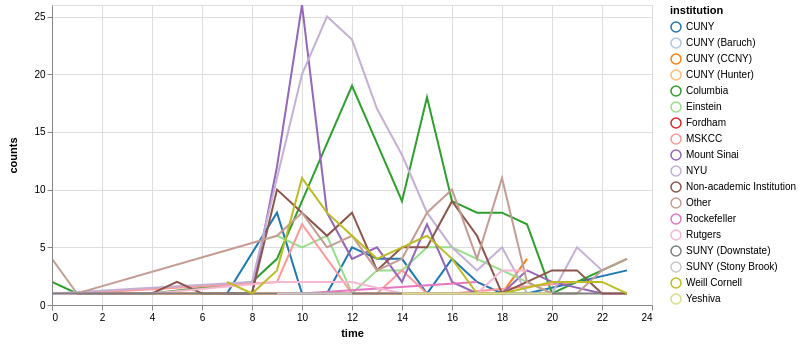

In [13]:
alt.Chart(hourly_rsvps_institution).properties(width=600)\
.mark_line()\
.encode(
    x='time',
    y='counts',
    color=alt.Color('institution',
        scale=alt.Scale(scheme='category20')),
    tooltip='institution'
).interactive()

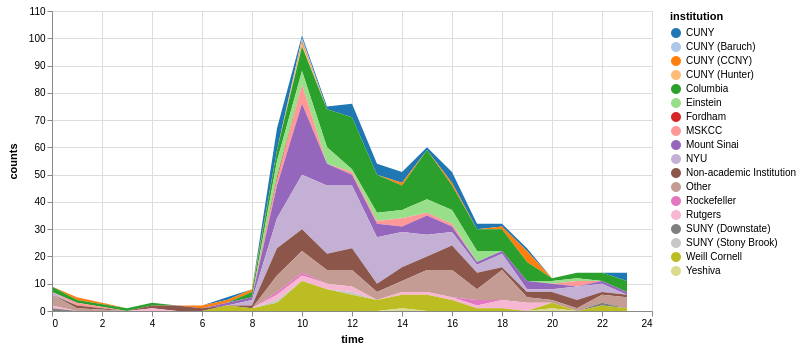

In [14]:
alt.Chart(hourly_rsvps_institution).properties(width=600)\
.mark_area()\
.encode(
    x='time',
    y=alt.Y('counts', stack='zero'),
    color=alt.Color('institution',
        scale=alt.Scale(scheme='category20')),
    tooltip='institution'
).interactive()

This shows that we got most of our RSVPs around 10 am. It is however important to keep in mind that:

a) RSVPs are usually do not necessarily have to be following an e-mail instantly, i.e. getting most RSVPs at 10 am means the best time to e-mail could be before then.

b) We tried to e-mail around 9 am, so our data collection is fundamentally biased. 

There is a second hump in the afternoon, because we would often send out an e-mail after lunch if we did not get to it before lunch. Some of the RSVPs during the nightly hours are likely by folks on conferences abroad or otherwise. What is somewhat surprising is the steady amouind of RSVPs from 8 pm to midnight - many folks checking their e-mails late at night.

Any of these hypothesis would need to be tested with varying e-mail timing randomly across a cohort. 

Even then it would be difficult to assess because if we randomly subselect for example NYU students, some of the recipients of the earlier e-mails could talk to their colleagues who receive later e-mails, enhancing the effectiveness of later e-mails.

## Summary

We have learned
* we can use RSVP data to analyse the response of our different communities
* repeated e-mails do not substantially lower the effectiveness of advertising (we don't generally e-mail more than once per day)
* repeated e-mail blasts over short periods of time may be highly effective (Columbia, 2 weeks before conference)
* peak response is at 10 am but likely due to when we usually send our e-mails